# Zeroshot Detection Using CLIP
- CLIP을 이용한 zeroshot Image Detection입니다.
- 기존 Classification Task와 달리 CLS토큰에 대한 임베딩 대신 각 패치에 대한 임베딩을 사용합니다.
  + 기존 CLIP은 전체 이미지에 대한 정보를 담은 CLS토큰을 이미지 임베딩으로 사용하여 각 패치에 대한 정보를 따로 사용하지 않습니다.

- 각 패치에 대한 임베딩과 텍스트['a photo of {class}']에  대한 임베딩 사이의 코사인 유사도를 구해 유사도가 높은 부분만을 표시하면 주어진 사물이 있는 위치만을 잡아낼 수 있겠다는 아이디어에서 출발합니다.


# 필요한 패키지 import, Clip 다운받기
- 구글 드라이브 마운트해서 이미지 불러왔습니다.
- 기존 방법처럼 Github에서 CLIP을 다운받으면 패치별 임베딩을 받아오는데 제한이 있어, Huggingface에 배포된 버전을 사용하기 위해 transformers 패키지를 설치 및 임포트했습니다.
- 그래서 각 이미지 패치에 대한 임베딩을 얻을 CLIPVisionModel, 텍스트 임베딩을 얻을 CLIPTokenizer, CLIPTextModel, 이후에 설명할 Visual_projection Layer을 불러오기 위한 전체 모델 CLIPModel을 따로 임포트해서 사용했습니다.
- 텍스트 모델과 비전 모델을 불러온 것과 별개로 전체 모델인 CLIPModel을 불러온 이유는 텍스트 임베딩과 이미지(각 패치에 대한)임베딩의 차원을 맞취주기 위해서입니다.
 + 원래 이미지 임베딩은 768차원으로 나온 다음에 visual_projection이라는 LInear 레이어를 거쳐 768->512 로 차원이 변경되는데, 패치별 임베딩을 얻기 위한 CLIPVIsionModel에는 그게 빠져있기 때문에 CLIPModel에서 Visual_projection Layer만 불러와서 패치별 임베딩을 통과시켜 차원을 텍스트 임베딩과 같은 512차원으로 바꿔줬습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 34.5 MB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 
     |████████████████████████████████| 120 kB 92.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn as nn
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPVisionModel, CLIPModel, CLIPTokenizer, CLIPTextModel
# 위 패키지 설명(순서대로) : 이미지 전처리 / 이미지 임베딩 얻기 / 차원변환 위한 전체모델 / 토크나이저 / 텍스트 임베딩 얻기 위한 텍스트 모델


In [ ]:
# 패치 하나의 크기가 (32 * 32)픽셀인 비전트랜스포머를 이미지 인코더로 사용한 CLIP 모델입니다.
clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# 이미지 임베딩의 차원을 768 -> 512으로 바꿔주는 Linear Layer를 따로 불러옵니다.
lintrans = clipmodel.visual_projection

In [ ]:
# 패치 임베딩(7개*7개 총 49개)을 얻기 위한 VisionModel(이미지 인코더)을 불러옵니다.
model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# 이미지 전처리를 위한 Processor도 불러옵니다. github 버전에서는 preprocess로 이름이 되어있습니다.
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.9.layer_norm1.weight', 'text_model.encoder.layers.8.self_attn.k_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.6.self_attn.v_proj.bias', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.7.layer_norm2.weight', 'text_model.encoder.layers.5.self_attn.o

# 이미지 임베딩, 텍스트 임베딩 구하기


In [ ]:
# 구글드라이브에서 이미지 하나를 불러옵니다.
image = Image.open('drive/My Drive/KUBIG/22_Summer_Contest/carsq.jpg')

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs) # output에는 여러개가 있으니 huggingface에서 참고하면 좋습니다.
last_hidden_state = outputs.last_hidden_state # 맨 앞의 CLS토큰에 대한 임베딩 + 49개의 패치 임베딩 -> 총 50개의 768차원 임베딩이 나옵니다.
pooled_output = outputs.pooler_output  # pooled CLS states # 맨 앞의 CLS 토큰에 대한 임베딩으로, 원래 CLIP은 이것만을 이미지 임베딩으로 이용합니다. 지금은 사용하지 않습니다.
                                       # CLS토큰이 전체 이미지에 대한 정보를 담고있기 때문입니다.

In [ ]:
# 맨 처음 CLS토큰 + 49개(7*7)의 패치에 대한 총 50개의 768차원 임베딩이 만들어집니다.
# 텍스트 임베딩은 512차원이므로 CLIPModel에서 이미지 임베딩의 차원을 768->512로 줄여주는 Linear Layer(당연히 pretrained)불러와야 합니다.
last_hidden_state.shape

torch.Size([1, 50, 768])

In [ ]:
# 맨 처음 CLS토큰은 필요없으니 빼고, 49개의 패치 임베딩을 위에서 언급한 Linear Layer에 통과시켜 512차원으로 만듭니다.
patch_embeddings = lintrans(last_hidden_state[:,0:49,:])

In [ ]:
# [1*49*512] -> [49*512] 로 맨 처음 필요없는 차원을 줄여줍니다.
patch_embeddings = patch_embeddings.squeeze()

In [ ]:
# 49개 패치에 대한 512차원 임베딩이 만들어진걸 확인할 수 있습니다.
patch_embeddings.shape

torch.Size([49, 512])

In [ ]:
# 이제는 텍스트 임베딩을 얻기 위해 토크나이저를 불러옵니다.
# 전체 CLIPModel을 위에서 이미 불러왔기 때문에 TextModel을 굳이 따로 불러오지 않습니다.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
textmodel = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.4.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vi

In [ ]:
# 자동차 이미지를 사용할 것이기 때문에 'a photo of a car'라는 문장을 Input으로 사용합니다.
inputs = tokenizer(["a photo of a car"], padding=True, return_tensors="pt")
text_pooled_output = textmodel(**inputs).pooler_output # 텍스트 모델을 이용해 텍스트 임베딩을 얻습니다.

# Similarity 구하기 + 시각화
- 이미지(49개의 패치) 임베딩과 텍스트 임베딩의 코사인 유사도를 구하는 과정입니다.

In [ ]:
# norm으로 나눠준 패치 임베딩
patch_embeddingsn = patch_embeddings / patch_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
# norm으로 나눠준 텍스트 임베딩
text_pooled_outputn = text_pooled_output / text_pooled_output.norm(dim=-1, keepdim=True)

In [ ]:
# 내적해서 코사인 유사도 구하기
similarities = (patch_embeddingsn @ text_pooled_outputn.T)

In [ ]:
# 어텐션 맵처럼 구현하기 위해 7*7 로 reshape
sim_mat = similarities.reshape(7,7).detach().numpy()

In [ ]:
# 좀 더 이쁘게 표현하기 위한 업샘플링
sim = nn.Upsample(224, mode='bicubic')(torch.Tensor(sim_mat).unsqueeze(0).unsqueeze(0))[0,0,:,:].numpy()

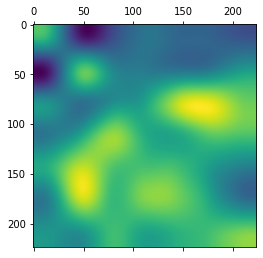

In [ ]:
# 밝은 부분이 유사도가 높은 부분(패치)입니다. 아래의 자동차 이미와 비교해보면 대략적으로 자동차의 위치를 파악할 수 있습니다.
plt.matshow(sim) # 성능이 좋지는 않습니다.

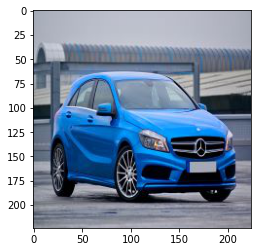

In [ ]:
plt.imshow(image)

# Car2
- 다른 데이터(여전히 자동차)에 대해서도 같은 실험을 해봅니다.

In [ ]:
image = Image.open('drive/My Drive/KUBIG/22_Summer_Contest/car2sq.jpg')

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

In [ ]:
patch_embeddings = lintrans(last_hidden_state[:,0:49,:])

In [ ]:
patch_embeddings = patch_embeddings.squeeze()

In [ ]:
inputs = tokenizer(["a photo of a car"], padding=True, return_tensors="pt")
text_pooled_output = textmodel(**inputs).pooler_output # 텍스트 모델을 이용해 텍스트 임베딩을 얻습니다.

In [ ]:
patch_embeddingsn = patch_embeddings / patch_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
text_pooled_outputn = text_pooled_output / text_pooled_output.norm(dim=-1, keepdim=True)

In [ ]:
similarities = (patch_embeddingsn @ text_pooled_outputn.T)

In [ ]:
sim_mat = similarities.reshape(7,7).detach().numpy()

In [ ]:
sim = nn.Upsample(224, mode='bicubic')(torch.Tensor(sim_mat).unsqueeze(0).unsqueeze(0))[0,0,:,:].numpy()

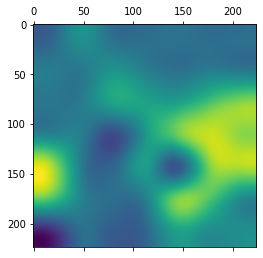

In [ ]:
# 너무 쉬운 사진이라 위에보다는 성능이 잘 나오는 것 같습니다.
import matplotlib.pyplot as plt
plt.matshow(sim)

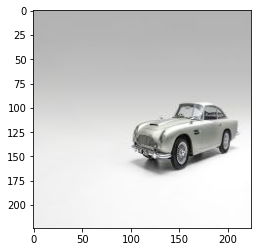

In [ ]:
plt.imshow(image)

# Car3
- 다른 데이터셋(여전히 자동차)에 대해서도 같은 실험을 해봅니다.

In [ ]:
image = Image.open('drive/My Drive/KUBIG/22_Summer_Contest/car3.jpg')

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

In [ ]:
patch_embeddings = lintrans(last_hidden_state[:,0:49,:])

In [ ]:
patch_embeddings = patch_embeddings.squeeze()

In [ ]:
inputs = tokenizer(["a photo of a car"], padding=True, return_tensors="pt")
text_pooled_output = textmodel(**inputs).pooler_output # 텍스트 모델을 이용해 텍스트 임베딩을 얻습니다.

In [ ]:
patch_embeddingsn = patch_embeddings / patch_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
text_pooled_outputn = text_pooled_output / text_pooled_output.norm(dim=-1, keepdim=True)

In [ ]:
similarities = (patch_embeddingsn @ text_pooled_outputn.T)

In [ ]:
sim_mat = similarities.reshape(7,7).detach().numpy()

In [ ]:
sim = nn.Upsample(224, mode='bicubic')(torch.Tensor(sim_mat).unsqueeze(0).unsqueeze(0))[0,0,:,:].numpy()

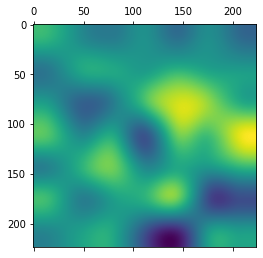

In [ ]:
plt.matshow(sim)

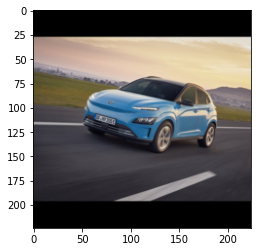

In [ ]:
plt.imshow(image)

#Car8


In [ ]:
image = Image.open('drive/My Drive/KUBIG/22_Summer_Contest/car8.jfif')

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

In [ ]:
patch_embeddings = lintrans(last_hidden_state[:,0:49,:])

In [ ]:
patch_embeddings = patch_embeddings.squeeze()

In [ ]:
inputs = tokenizer(["a photo of a car"], padding=True, return_tensors="pt")
text_pooled_output = textmodel(**inputs).pooler_output # 텍스트 모델을 이용해 텍스트 임베딩을 얻습니다.

In [ ]:
patch_embeddingsn = patch_embeddings / patch_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
text_pooled_outputn = text_pooled_output / text_pooled_output.norm(dim=-1, keepdim=True)

In [ ]:
similarities = (patch_embeddingsn @ text_pooled_outputn.T)

In [ ]:
sim_mat = similarities.reshape(7,7).detach().numpy()

In [ ]:
sim = nn.Upsample(224, mode='bicubic')(torch.Tensor(sim_mat).unsqueeze(0).unsqueeze(0))[0,0,:,:].numpy()

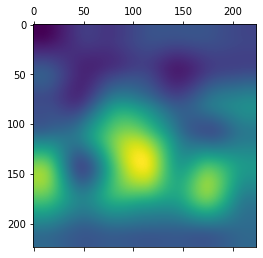

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(sim)

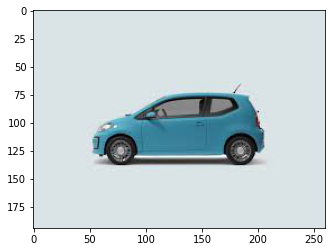

In [ ]:
plt.imshow(image)